<a href="https://colab.research.google.com/github/RajSingh23/Projects/blob/main/MLP_analysis_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The task is to create a two layer MLP that will classify text data from IMDB reviews and analyze different choices for hyperparameters. The dataset is the IMDB dataset from pytorch that contains text data for reviews and labels that identify the review as positive and negative. The number of layers is 100 at the start and the learning rate is 1.0

In [ ]:
!pip install torch==2.3.0 torchtext==0.18.0 torchdata
!pip install portalocker>=2.0.0

In [ ]:
# import datasets
from torchtext.datasets import IMDB
import portalocker
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string
import sentencepiece as spm
import statistics as stats
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

#Splitting data into training and testing
train_iter = IMDB(split='train')
train_data = [(label, line) for label, line in train_iter]
train_df = pd.DataFrame(train_data, columns=['label', 'text'])

valid_dataset = IMDB(split='test')
valid_data = [(label, line) for label, line in valid_dataset]
valid_df = pd.DataFrame(valid_data, columns=['label', 'text'])

# Clean the text data

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train_df['text_clean'] = train_df['text'].apply(clean_text)
valid_df['text_clean'] = valid_df['text'].apply(clean_text)

train_df['label'] = train_df['label'].replace(1, 0)
train_df['label'] = train_df['label'].replace(2, 1)
valid_df['label'] = valid_df['label'].replace(1, 0)
valid_df['label'] = valid_df['label'].replace(2, 1)

In [ ]:
!mkdir preprocessed_data
# save the cleaned texts as a plain file which is going to be the input for learning BPE tokenization
with open('preprocessed_data/train.text', 'w') as f:
  for text in train_df['text_clean']:
    f.write(f'{text.strip()}\n')

VOCAB_SIZE = 8000

# learn a BPE tokenization model
spm.SentencePieceTrainer.train(input='preprocessed_data/train.text', model_prefix='bpe_model', vocab_size=VOCAB_SIZE, model_type='bpe')

sp = spm.SentencePieceProcessor(model_file='bpe_model.model')

def tokenize_into_str(text):
  return ' '.join(sp.encode(text, out_type=str))

def tokenize_into_idx(text):
  return ' '.join([str(tok) for tok in sp.encode(text)])

train_df['text_tokenized'] = train_df['text_clean'].apply(tokenize_into_str)
train_df['text_indices'] = train_df['text_clean'].apply(tokenize_into_idx)
train_df['text_indices'].replace('', np.nan, inplace=True)
train_df.dropna(subset=['text_indices'], inplace=True)
train_df.head()

mkdir: cannot create directory ‘preprocessed_data’: File exists


,label,text,text_clean,text_tokenized,text_indices
0,0,I rented I AM CURIOUS-YELLOW from my video sto...,i rented i am curiousyellow from my video stor...,▁i ▁rented ▁i ▁am ▁curious ye llow ▁from ▁my ▁...,6 3518 6 260 4297 4458 789 177 222 1251 2756 3...
1,0,"""I Am Curious: Yellow"" is a risible and preten...",i am curious yellow is a risible and pretentio...,▁i ▁am ▁curious ▁yellow ▁is ▁a ▁ris ible ▁and ...,6 260 4297 7446 42 4 3926 661 30 4104 720 4879...
2,0,If only to avoid making this type of film in t...,if only to avoid making this type of film in t...,▁if ▁only ▁to ▁avoid ▁making ▁this ▁type ▁of ▁...,214 266 32 2031 853 62 1671 33 89 40 7 1928 62...
3,0,This film was probably inspired by Godard's Ma...,this film was probably inspired by godards mas...,▁this ▁film ▁was ▁probably ▁inspired ▁by ▁god ...,62 89 78 815 3746 163 1271 1459 14 2034 128 11...
4,0,"Oh, brother...after hearing about this ridicul...",oh brotherafter hearing about this ridiculous ...,▁oh ▁brother after ▁hearing ▁about ▁this ▁ridi...,1388 1693 4148 4685 198 62 1663 89 85 6916 219...


In [ ]:
valid_df['text_tokenized'] = valid_df['text_clean'].apply(tokenize_into_str)
valid_df['text_indices'] = valid_df['text_clean'].apply(tokenize_into_idx)
valid_df['text_indices'].replace('', np.nan, inplace=True)
valid_df.dropna(subset=['text_indices'], inplace=True)
valid_df.head()

,label,text,text_clean,text_tokenized,text_indices
0,0,I love sci-fi and am willing to put up with a ...,i love scifi and am willing to put up with a l...,▁i ▁love ▁scifi ▁and ▁am ▁willing ▁to ▁put ▁up...,6 418 2507 30 260 3706 32 758 240 94 4 536 250...
1,0,"Worth the entertainment value of a rental, esp...",worth the entertainment value of a rental espe...,▁worth ▁the ▁entertainment ▁value ▁of ▁a ▁rent...,783 7 1956 2720 33 4 4923 894 214 95 172 723 3...
2,0,its a totally average film with a few semi-alr...,its a totally average film with a few semialri...,▁its ▁a ▁totally ▁average ▁film ▁with ▁a ▁few ...,151 4 1452 2226 89 94 4 608 3739 599 1350 723 ...
3,0,STAR RATING: ***** Saturday Night **** Friday ...,star rating saturday night friday night fri...,▁star ▁rating ▁saturday ▁night ▁friday ▁night ...,787 1707 4819 813 5125 813 5125 4236 5471 813 ...
4,0,"First off let me say, If you haven't enjoyed a...",first off let me say if you havent enjoyed a v...,▁first ▁off ▁let ▁me ▁say ▁if ▁you ▁havent ▁en...,352 374 767 190 445 214 95 2020 1467 4 2043 17...


In [ ]:
def count_tokens(text_indices):
  tokens = text_indices.split(' ')
  return len(tokens)

In [ ]:
train_df['sequence_length'] = train_df['text_indices'].apply(count_tokens)
valid_df['sequence_length'] = valid_df['text_indices'].apply(count_tokens)

print(f"Train:\tmean={stats.mean(train_df['sequence_length']):.2f}\tstd={stats.stdev(train_df['sequence_length']):.2f}")
print(f"Test:\tmean={stats.mean(valid_df['sequence_length']):.2f}\tstd={stats.stdev(valid_df['sequence_length']):.2f}")

Train:	mean=268.81	std=207.25
Test:	mean=263.51	std=202.07


In [ ]:
# serialize
train_df.to_pickle('preprocessed_data/train.pkl')
valid_df.to_pickle('preprocessed_data/valid.pkl')

In [ ]:
class IMDBReviewsDataset(Dataset):
  def __init__(self, pickle_path):
    self.dataset = pd.read_pickle(pickle_path)

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    text_indices_string = self.dataset['text_indices'].iloc[idx]
    text_indices = [int(tok_idx) for tok_idx in text_indices_string.split(' ')]
    sequence_length = int(self.dataset['sequence_length'].iloc[idx])
    label = None
    if 'label' in self.dataset.columns:
      label = int(self.dataset['label'].iloc[idx])
    return text_indices, sequence_length, label


In [ ]:
train_dataset = IMDBReviewsDataset('preprocessed_data/train.pkl')
valid_dataset = IMDBReviewsDataset('preprocessed_data/valid.pkl')
print(train_dataset[0])
print(valid_dataset[0])

([6, 3518, 6, 260, 4297, 4458, 789, 177, 222, 1251, 2756, 353, 33, 145, 7, 5294, 7990, 64, 6735, 46, 239, 46, 78, 352, 1807, 40, 6, 357, 1631, 64, 120, 352, 46, 78, 92, 1356, 163, 335, 5455, 5899, 214, 46, 454, 2183, 32, 4024, 62, 1713, 3757, 436, 4, 929, 33, 382, 2931, 6558, 6, 263, 268, 32, 238, 62, 85, 1554, 423, 413, 42, 1334, 1590, 689, 4, 594, 7227, 1457, 3472, 2140, 36, 3964, 146, 1484, 32, 1570, 966, 250, 246, 198, 458, 40, 2261, 250, 1484, 32, 1834, 169, 509, 66, 487, 32, 853, 173, 1223, 33, 1819, 63, 217, 7, 2226, 5535, 7974, 649, 198, 1000, 2594, 3113, 529, 82, 7, 5612, 648, 30, 3643, 3113, 40, 7, 5179, 3754, 40, 730, 4889, 7225, 1787, 30, 4348, 1987, 443, 422, 33, 3722, 3430, 7986, 198, 277, 1664, 487, 63, 5167, 250, 204, 729, 94, 169, 1457, 3887, 726, 5620, 30, 2539, 1042, 1310, 2673, 190, 198, 6, 260, 4297, 4458, 789, 42, 64, 573, 1709, 62, 78, 2931, 3010, 6762, 263, 7, 729, 30, 2510, 517, 117, 608, 30, 667, 730, 256, 388, 151, 109, 788, 172, 173, 1676, 60, 369, 6351, 907

In [ ]:
def generate_batch(batch):
  batch_indices = []
  batch_labels = []
  offsets = [0]

  for text_indices, sequence_length, label in batch:
    batch_indices.extend(text_indices)
    batch_labels.append(label)
    offsets.append(sequence_length)

  batch_indices = torch.tensor(batch_indices, dtype=torch.long)
  batch_labels = torch.tensor(batch_labels, dtype=torch.long)
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
  return batch_indices, offsets, batch_labels

BATCH_SIZE = 8
EMBED_DIM = 32
NUM_CLASS = 2

In [ ]:
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        # self.fc = nn.Linear(embed_dim, num_class)
        self.fc1 = nn.Linear(embed_dim, 100)
        self.fc2 = nn.Linear(100, num_class)
        # initialize the weights
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc2(self.fc1(embedded))

In [ ]:
model = MLP(VOCAB_SIZE, EMBED_DIM, NUM_CLASS).to(device)

In [ ]:
def train_func(train_loader):
    # Train the model
    train_loss = 0
    train_acc = 0
    total_size = 0
    for i, (text, offsets, cls) in enumerate(train_loader):
        total_size += len(cls)
        optimizer.zero_grad() # clear the gradients
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        # forward pass
        output = model(text, offsets)
        # get the loss
        loss = criterion(output, cls)
        train_loss += loss.item()
        # calculate gradients
        loss.backward()
        # update weights
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()
    # Adjust the learning rate
    scheduler.step()
    return train_loss / total_size, train_acc / total_size

def valid_func(valid_loader):
    loss = 0
    acc = 0
    total_size = 0
    for text, offsets, cls in valid_loader:
        total_size += len(cls)
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()
    return loss / total_size, acc / total_size

In [ ]:
N_EPOCHS = 25
t = time.time()
loss=[]
acc=[]
val_acc=[]

min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_func(train_loader)
    valid_loss, valid_acc = valid_func(valid_loader)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')

    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)

print(f'time:{time.time()-t:.3f}')

	Train Loss: 0.073 | Train Acc: 68.55%
	 Val. Acc: 73.35%
	Train Loss: 0.052 | Train Acc: 81.66%
	 Val. Acc: 80.88%
	Train Loss: 0.044 | Train Acc: 85.24%
	 Val. Acc: 82.54%
	Train Loss: 0.039 | Train Acc: 87.12%
	 Val. Acc: 71.70%
	Train Loss: 0.036 | Train Acc: 88.42%
	 Val. Acc: 87.06%
	Train Loss: 0.033 | Train Acc: 89.51%
	 Val. Acc: 86.80%
	Train Loss: 0.031 | Train Acc: 90.00%
	 Val. Acc: 86.44%
	Train Loss: 0.029 | Train Acc: 90.77%
	 Val. Acc: 77.12%
	Train Loss: 0.028 | Train Acc: 91.04%
	 Val. Acc: 85.64%
	Train Loss: 0.026 | Train Acc: 91.63%
	 Val. Acc: 87.31%
	Train Loss: 0.026 | Train Acc: 91.85%
	 Val. Acc: 86.84%
	Train Loss: 0.024 | Train Acc: 92.45%
	 Val. Acc: 84.20%
	Train Loss: 0.023 | Train Acc: 92.64%
	 Val. Acc: 83.94%
	Train Loss: 0.023 | Train Acc: 93.05%
	 Val. Acc: 86.85%
	Train Loss: 0.022 | Train Acc: 93.27%
	 Val. Acc: 86.82%
	Train Loss: 0.021 | Train Acc: 93.55%
	 Val. Acc: 86.74%
	Train Loss: 0.021 | Train Acc: 93.71%
	 Val. Acc: 85.94%
	Train Loss: 0

<function matplotlib.pyplot.show(close=None, block=None)>

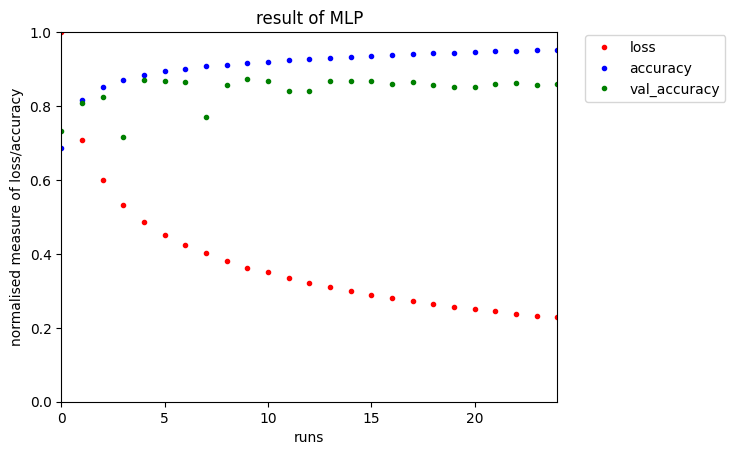

In [ ]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of MLP')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

Now we will see the performance of the single layer MLP and compare it to the performance of the two layer MLP.

In [ ]:
class MLP2(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        # initialize the weights
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [ ]:
model = MLP2(VOCAB_SIZE, EMBED_DIM, NUM_CLASS).to(device)

In [ ]:
def train_func(train_loader):
    # Train the model
    train_loss = 0
    train_acc = 0
    total_size = 0
    for i, (text, offsets, cls) in enumerate(train_loader):
        total_size += len(cls)
        optimizer.zero_grad() # clear the gradients
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        # forward pass
        output = model(text, offsets)
        # get the loss
        loss = criterion(output, cls)
        train_loss += loss.item()
        # calculate gradients
        loss.backward()
        # update weights
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()
    # Adjust the learning rate
    scheduler.step()
    return train_loss / total_size, train_acc / total_size

def valid_func(valid_loader):
    loss = 0
    acc = 0
    total_size = 0
    for text, offsets, cls in valid_loader:
        total_size += len(cls)
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()
    return loss / total_size, acc / total_size

In [ ]:
N_EPOCHS = 25
t = time.time()
loss=[]
acc=[]
val_acc=[]

min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_func(train_loader)
    valid_loss, valid_acc = valid_func(valid_loader)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')

    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)

print(f'time:{time.time()-t:.3f}')

	Train Loss: 0.067 | Train Acc: 71.94%
	 Val. Acc: 73.08%
	Train Loss: 0.046 | Train Acc: 83.52%
	 Val. Acc: 85.36%
	Train Loss: 0.040 | Train Acc: 86.78%
	 Val. Acc: 86.06%
	Train Loss: 0.036 | Train Acc: 88.32%
	 Val. Acc: 85.31%
	Train Loss: 0.033 | Train Acc: 89.32%
	 Val. Acc: 85.55%
	Train Loss: 0.031 | Train Acc: 90.15%
	 Val. Acc: 84.70%
	Train Loss: 0.029 | Train Acc: 90.70%
	 Val. Acc: 83.97%
	Train Loss: 0.028 | Train Acc: 91.36%
	 Val. Acc: 87.14%
	Train Loss: 0.026 | Train Acc: 91.73%
	 Val. Acc: 87.10%
	Train Loss: 0.025 | Train Acc: 92.09%
	 Val. Acc: 86.24%
	Train Loss: 0.025 | Train Acc: 92.32%
	 Val. Acc: 87.06%
	Train Loss: 0.024 | Train Acc: 92.80%
	 Val. Acc: 84.75%
	Train Loss: 0.023 | Train Acc: 92.98%
	 Val. Acc: 86.32%
	Train Loss: 0.022 | Train Acc: 93.17%
	 Val. Acc: 86.89%
	Train Loss: 0.022 | Train Acc: 93.60%
	 Val. Acc: 86.70%
	Train Loss: 0.021 | Train Acc: 93.56%
	 Val. Acc: 86.88%
	Train Loss: 0.021 | Train Acc: 93.90%
	 Val. Acc: 86.89%
	Train Loss: 0

The accuracy of the model on test data after training is 86.66%

<function matplotlib.pyplot.show(close=None, block=None)>

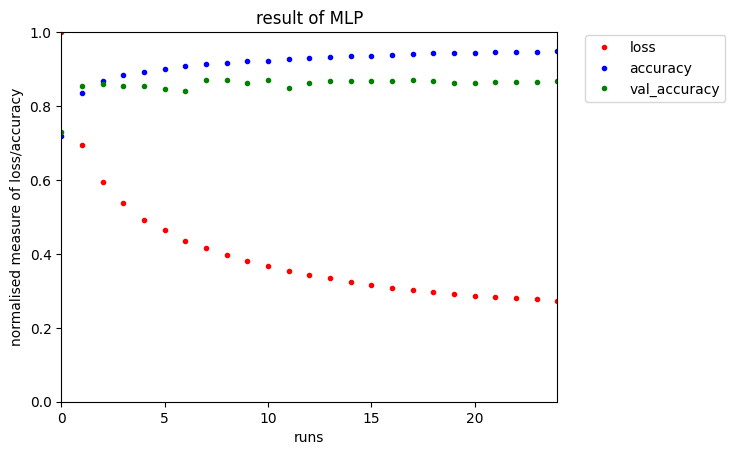

In [ ]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of MLP')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

The single layer MLP performs very similarly to the two layer MLP. This is because we are not adding any activation functions, so the model does not handle non-linearity better by adding the second layer.

Now we are going to see if there are any changes by increasing the number of layers from 100 to 200

In [ ]:
class MLP3(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        # self.fc = nn.Linear(embed_dim, num_class)
        self.fc1 = nn.Linear(embed_dim, 200)
        self.fc2 = nn.Linear(200, num_class)
        # initialize the weights
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc2(self.fc1(embedded))

In [ ]:
model = MLP3(VOCAB_SIZE, EMBED_DIM, NUM_CLASS).to(device)

In [ ]:
def train_func(train_loader):
    # Train the model
    train_loss = 0
    train_acc = 0
    total_size = 0
    for i, (text, offsets, cls) in enumerate(train_loader):
        total_size += len(cls)
        optimizer.zero_grad() # clear the gradients
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        # forward pass
        output = model(text, offsets)
        # get the loss
        loss = criterion(output, cls)
        train_loss += loss.item()
        # calculate gradients
        loss.backward()
        # update weights
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()
    # Adjust the learning rate
    scheduler.step()
    return train_loss / total_size, train_acc / total_size

def valid_func(valid_loader):
    loss = 0
    acc = 0
    total_size = 0
    predictions = []
    labels = []

    for text, offsets, cls in valid_loader:
        total_size += len(cls)
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()

            predicted_labels = output.argmax(1).cpu().numpy()
            true_labels = cls.cpu().numpy()

            predictions.extend(predicted_labels)
            labels.extend(true_labels)

            acc += (output.argmax(1) == cls).sum().item()
    return loss / total_size, acc / total_size, predictions, labels

In [ ]:
N_EPOCHS = 25
t = time.time()
loss=[]
acc=[]
val_acc=[]
preds=[]
labels=[]

min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=generate_batch)

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_func(train_loader)
    valid_loss, valid_acc, valid_predictions, valid_labels= valid_func(valid_loader)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')

    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)

    preds.extend(valid_predictions)
    labels.extend(valid_labels)


print(f'time:{time.time()-t:.3f}')

	Train Loss: 0.072 | Train Acc: 69.53%
	 Val. Acc: 65.94%
	Train Loss: 0.052 | Train Acc: 81.91%
	 Val. Acc: 80.06%
	Train Loss: 0.043 | Train Acc: 85.32%
	 Val. Acc: 81.65%
	Train Loss: 0.039 | Train Acc: 87.45%
	 Val. Acc: 86.32%
	Train Loss: 0.036 | Train Acc: 88.38%
	 Val. Acc: 86.97%
	Train Loss: 0.033 | Train Acc: 89.48%
	 Val. Acc: 84.84%
	Train Loss: 0.031 | Train Acc: 89.92%
	 Val. Acc: 86.55%
	Train Loss: 0.029 | Train Acc: 90.56%
	 Val. Acc: 80.63%
	Train Loss: 0.028 | Train Acc: 91.14%
	 Val. Acc: 86.71%
	Train Loss: 0.026 | Train Acc: 91.62%
	 Val. Acc: 86.45%
	Train Loss: 0.025 | Train Acc: 91.91%
	 Val. Acc: 87.19%
	Train Loss: 0.024 | Train Acc: 92.42%
	 Val. Acc: 87.00%
	Train Loss: 0.023 | Train Acc: 92.81%
	 Val. Acc: 85.69%
	Train Loss: 0.023 | Train Acc: 92.89%
	 Val. Acc: 86.13%
	Train Loss: 0.022 | Train Acc: 93.23%
	 Val. Acc: 85.64%
	Train Loss: 0.021 | Train Acc: 93.76%
	 Val. Acc: 86.62%
	Train Loss: 0.020 | Train Acc: 93.67%
	 Val. Acc: 85.96%
	Train Loss: 0

<function matplotlib.pyplot.show(close=None, block=None)>

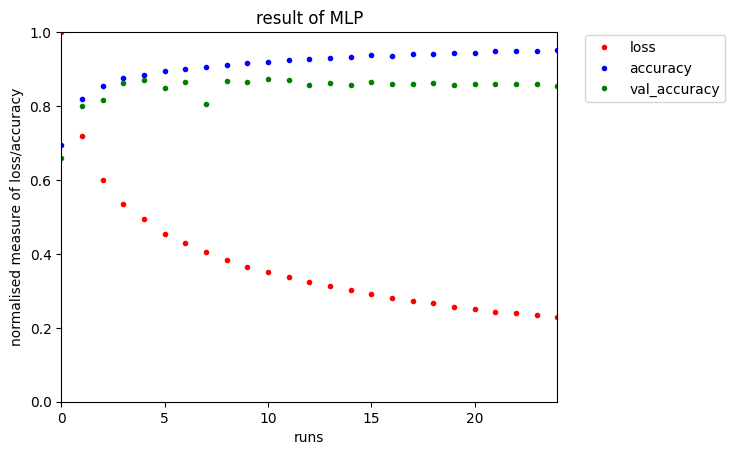

In [ ]:
plt.xlabel("runs")
plt.ylabel("normalised measure of loss/accuracy")
x_len=list(range(len(acc)))
plt.axis([0, max(x_len), 0, 1])
plt.title('result of MLP')
loss=np.asarray(loss)/max(loss)
plt.plot(x_len, loss, 'r.',label="loss")
plt.plot(x_len, acc, 'b.', label="accuracy")
plt.plot(x_len, val_acc, 'g.', label="val_accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

Adding more dimensions to the intermediate layer does not improve the model performance. Increasing dimensions does not necessarily improve model performance because overfitting can occur or the 100 layers is already sufficient.

In [ ]:
incorrect_samples = []

# Finds test data that the model incorrectly classified
for i in range(len(preds)):
    if preds[i] != labels[i]:
        incorrect_samples.append({
            'index': i,
            'predicted': preds[i],
            'true': labels[i]
        })

print(f"Total incorrect predictions: {len(incorrect_samples)}\n")

# https://www.geeksforgeeks.org/enumerate-in-python/ --> Used as reference
for i, sample in enumerate(incorrect_samples[1000:1020]):
    idx = sample['index']
    text = valid_df.loc[idx, 'text_clean']

    print(f"Sample {i+1}:")
    print(f"Text: {text}")
    print(f"Predicted Label: {sample['predicted']}, True Label: {sample['true']}")
    print("-" * 80)

Total incorrect predictions: 95514

Sample 1:
Text: writerdirector john milius takes a littleknown incident from american history and extrapolates wildly in all the right ways the result is a grand adventure tale that showcases two of its stars in memorable largerthanlife roles sean connery as the wily arab sheik with an inexplicable scottish brogue and brian keith as president theodore roosevelt itching for the chance to put that big stick to good useaided immeasurably by billy williams glorious widescreen cinematography and a magnificent score by the always reliable jerry goldsmith this early effort seemed the harbinger of a talent to rank with contemporaries lucas coppola and spielberg although milius served up tantalizing glimpses of his ability in scripts for jeremiah johnson and apocalypse now his career seemed to take a downward turn not long after he started directing ultimately foundering on dreck like conan the barbarian and red dawn heres hoping that he will again find his w

Many of the reviews that the model incorrectly classifies seem to have a level of nuance to them. One word I've noticed a few times is "even", which is a word often used when someone is bringing forward a point of nuance. There are often some words that are generally viewed as positive or negative that seem to confuse the model when included in a review that has the opposite sentiment overall.